# ArangoDB DGL Adapter Getting Started Guide  

<a href="https://colab.research.google.com/github/arangoml/dgl-adapter/blob/3.0.0/examples/ArangoDB_DGL_Adapter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![arangodb](https://raw.githubusercontent.com/arangoml/dgl-adapter/master/examples/assets/adb_logo.png)
<img src="https://raw.githubusercontent.com/arangoml/dgl-adapter/master/examples/assets/dgl_logo.png" width=40% />

Version: 3.0.0

Objective: Export Graphs from [ArangoDB](https://www.arangodb.com/), a multi-model Graph Database, to [Deep Graph Library](https://www.dgl.ai/) (DGL), a python package for graph neural networks, and vice-versa.

# Setup

In [ ]:
%%capture
!pip install adbdgl-adapter==3.0.0
!pip install adb-cloud-connector
!git clone -b 3.0.0 --single-branch https://github.com/arangoml/dgl-adapter.git

## For drawing purposes
!pip install matplotlib
!pip install networkx

In [ ]:
# All imports

import pandas
import torch
import dgl
from dgl.data import KarateClubDataset

from arango import ArangoClient
from adb_cloud_connector import get_temp_credentials

from adbdgl_adapter import ADBDGL_Adapter, ADBDGL_Controller
from adbdgl_adapter.encoders import IdentityEncoder, CategoricalEncoder

import json
import logging

import matplotlib.pyplot as plt
import networkx as nx

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


# Understanding DGL

(referenced from [docs.dgl.ai](https://docs.dgl.ai/en/0.6.x/))


Deep Graph Library (DGL) is a Python package built for easy implementation of graph neural network model family, on top of existing DL frameworks (currently supporting **PyTorch**, **MXNet** and **TensorFlow**).

DGL represents a directed graph as a `DGLGraph` object. You can construct a graph by specifying the number of nodes in the graph as well as the list of source and destination nodes. **Nodes in the graph have consecutive IDs starting from 0.**

The following code constructs a directed "star" homogeneous graph with 6 nodes and 5 edges.


In [ ]:
# A homogeneous graph with 6 nodes, and 5 edges
g = dgl.graph(([0, 0, 0, 0, 0], [1, 2, 3, 4, 5]))
print(g)

# Print the graph's canonical edge types
print("\nCanonical Edge Types: ", g.canonical_etypes)
# >>> [('_N', '_E', '_N')]
# '_N' being the only Node type
# '_E' being the only Edge type

Graph(num_nodes=6, num_edges=5,
      ndata_schemes={}
      edata_schemes={})

Canonical Edge Types:  [('_N', '_E', '_N')]



In DGL, a heterogeneous graph (heterograph for short) is specified with a series of graphs as below, one per relation. Each relation is a string triplet `(source node type, edge type, destination node type)`. Since relations disambiguate the edge types, DGL calls them canonical edge types:

In [ ]:
# A heterogeneous graph with 8 nodes, and 7 edges
g = dgl.heterograph({
    ('user', 'follows', 'user'): (torch.tensor([0, 1]), torch.tensor([1, 2])),
    ('user', 'follows', 'game'): (torch.tensor([0, 1, 2]), torch.tensor([1, 2, 3])),
    ('user', 'plays', 'game'): (torch.tensor([1, 3]), torch.tensor([2, 3]))
})

print(g)
print("\nCanonical Edge Types: ", g.canonical_etypes)
print("\nNode Types: ", g.ntypes)
print("\nEdge Types: ", g.etypes)

Graph(num_nodes={'game': 4, 'user': 4},
      num_edges={('user', 'follows', 'game'): 3, ('user', 'follows', 'user'): 2, ('user', 'plays', 'game'): 2},
      metagraph=[('user', 'game', 'follows'), ('user', 'game', 'plays'), ('user', 'user', 'follows')])

Canonical Edge Types:  [('user', 'follows', 'game'), ('user', 'follows', 'user'), ('user', 'plays', 'game')]

Node Types:  ['game', 'user']

Edge Types:  ['follows', 'follows', 'plays']


Many graph data contain attributes on nodes and edges. Although the types of node and edge attributes can be arbitrary in real world, **DGLGraph only accepts attributes stored in tensors** (with numerical contents). Consequently, an attribute of all the nodes or edges must have the same shape. In the context of deep learning, those attributes are often called features.

You can assign and retrieve node and edge features via ndata and edata interface.

In [ ]:
# A homogeneous graph with 6 nodes, and 5 edges
g = dgl.graph(([0, 0, 0, 0, 0], [1, 2, 3, 4, 5]))

# Assign an integer value for each node.
g.ndata['x'] = torch.tensor([151, 124, 41, 89, 76, 55])
# Assign a 4-dimensional edge feature vector for each edge.
g.edata['a'] = torch.randn(5, 4)

print(g)
print("\nNode Data X attribute: ", g.ndata['x'])
print("\nEdge Data A attribute: ", g.edata['a'])


# NOTE: The following line ndata insertion will fail, since not all nodes have been assigned an attribute value
# g.ndata['bad_attribute'] = torch.tensor([0,10,20,30,40])

Graph(num_nodes=6, num_edges=5,
      ndata_schemes={'x': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'a': Scheme(shape=(4,), dtype=torch.float32)})

Node Data X attribute:  tensor([151, 124,  41,  89,  76,  55])

Edge Data A attribute:  tensor([[ 0.6125,  0.4397, -0.4108, -0.6406],
        [-0.4089, -0.3135, -0.8268,  0.2150],
        [-0.5285, -1.7320,  0.5904, -0.2922],
        [ 0.3878,  0.1858,  0.9546, -0.4877],
        [ 1.4629, -1.9385, -2.1406, -0.1621]])


When multiple node/edge types are introduced, users need to specify the particular node/edge type when invoking a DGLGraph API for type-specific information. In addition, nodes/edges of different types have separate IDs.

In [ ]:
g = dgl.heterograph({
    ('user', 'follows', 'user'): (torch.tensor([0, 1]), torch.tensor([1, 2])),
    ('user', 'follows', 'game'): (torch.tensor([0, 1, 2]), torch.tensor([1, 2, 3])),
    ('user', 'plays', 'game'): (torch.tensor([1, 3]), torch.tensor([2, 3]))
})

# Get the number of all nodes in the graph
print("All nodes: ", g.num_nodes())

# Get the number of user nodes
print("User nodes: ", g.num_nodes('user'))

# Nodes of different types have separate IDs,
# hence not well-defined without a type specified
# print(g.nodes())
#DGLError: Node type name must be specified if there are more than one node types.

print(g.nodes('user'))

All nodes:  8
User nodes:  4
tensor([0, 1, 2, 3])


To set/get features for a specific node/edge type, DGL provides two new types of syntax – g.nodes[‘node_type’].data[‘feat_name’] and g.edges[‘edge_type’].data[‘feat_name’].

**Note:** If the graph only has one node/edge type, there is no need to specify the node/edge type.

In [ ]:
g = dgl.heterograph({
    ('user', 'follows', 'user'): (torch.tensor([0, 1]), torch.tensor([1, 2])),
    ('user', 'follows', 'game'): (torch.tensor([0, 1, 2]), torch.tensor([1, 2, 3])),
    ('user', 'plays', 'game'): (torch.tensor([1, 3]), torch.tensor([2, 3]))
})

g.nodes['user'].data['age'] = torch.tensor([21, 16, 38, 64])
# An alternative (yet equivalent) syntax:
# g.ndata['age'] = {'user': torch.tensor([21, 16, 38, 64])}

print(g.ndata)

defaultdict(<class 'dict'>, {'age': {'user': tensor([21, 16, 38, 64])}})


For more info, visit https://docs.dgl.ai/en/0.6.x/.

# Create a Temporary ArangoDB Cloud Instance

In [ ]:
# Request temporary instance from the managed ArangoDB Cloud Service.
con = get_temp_credentials()
print(json.dumps(con, indent=2))

# Connect to the db via the python-arango driver
db = ArangoClient(hosts=con["url"]).db(con["dbName"], con["username"], con["password"], verify=True)

Log: requesting new credentials...
Succcess: new credentials acquired
{
  "dbName": "TUTk9nlikuz4zowwxfkusway",
  "username": "TUT6h05us6483maimfr7o28jq",
  "password": "TUTis4noysrzjeig2bqpdccaa",
  "hostname": "tutorials.arangodb.cloud",
  "port": 8529,
  "url": "https://tutorials.arangodb.cloud:8529"
}


Feel free to use to above URL to checkout the UI!

# Data Import

For demo purposes, we will be using the [ArangoDB IMDB example graph](https://www.arangodb.com/docs/stable/arangosearch-example-datasets.html#imdb-movie-dataset).

In [ ]:
!chmod -R 755 dgl-adapter/
!./dgl-adapter/tests/tools/arangorestore -c none --server.endpoint http+ssl://{con["hostname"]}:{con["port"]} --server.username {con["username"]} --server.database {con["dbName"]} --server.password {con["password"]} --replication-factor 3  --input-directory "dgl-adapter/tests/data/adb/imdb_dump" --include-system-collections true

2022-08-05T20:32:43Z [308] INFO [05c30] {restore} Connected to ArangoDB 'http+ssl://tutorials.arangodb.cloud:8529'
2022-08-05T20:32:43Z [308] INFO [abeb4] {restore} Database name in source dump is 'TUTdit9ohpgz1ntnbetsjstwi'
2022-08-05T20:32:43Z [308] INFO [9b414] {restore} # Re-creating document collection 'Movies'...
2022-08-05T20:32:43Z [308] INFO [9b414] {restore} # Re-creating document collection 'Users'...
2022-08-05T20:32:44Z [308] INFO [9b414] {restore} # Re-creating edge collection 'Ratings'...
2022-08-05T20:32:44Z [308] INFO [6d69f] {restore} # Dispatched 3 job(s), using 2 worker(s)
2022-08-05T20:32:44Z [308] INFO [94913] {restore} # Loading data into document collection 'Movies', data size: 68107 byte(s)
2022-08-05T20:32:44Z [308] INFO [94913] {restore} # Loading data into document collection 'Users', data size: 16717 byte(s)
2022-08-05T20:32:44Z [308] INFO [6ae09] {restore} # Successfully restored document collection 'Users'
2022-08-05T20:32:44Z [308] INFO [94913] {restore}

In [ ]:
# Create the IMDB graph
db.delete_graph("imdb", ignore_missing=True)
db.create_graph(
    "imdb",
    edge_definitions=[
        {
            "edge_collection": "Ratings",
            "from_vertex_collections": ["Users"],
            "to_vertex_collections": ["Movies"],
        },
    ],
)

<Graph imdb>

# Instantiate the Adapter

Connect the ArangoDB-DGL Adapter to our temporary ArangoDB cluster:

In [ ]:
adbdgl_adapter = ADBDGL_Adapter(db)

[2022/08/05 20:33:59 +0000] [61] [INFO] - adbdgl_adapter: Instantiated ADBDGL_Adapter with database 'TUTk9nlikuz4zowwxfkusway'


# <u>DGL to ArangoDB</u>

#### Karate Graph

Data
* [DGL Karate Graph](https://docs.dgl.ai/en/0.6.x/api/python/dgl.data.html#karate-club-dataset)

API
* `adbdgl_adapter.adapter.dgl_to_arangodb()`

Notes
* The `name` parameter in this case is simply for naming your ArangoDB graph.

Output()

Output()

[2022/08/05 20:34:04 +0000] [61] [INFO] - adbdgl_adapter: Created ArangoDB 'Karate' Graph



--------------------
URL: https://tutorials.arangodb.cloud:8529
Username: TUT6h05us6483maimfr7o28jq
Password: TUTis4noysrzjeig2bqpdccaa
Database: TUTk9nlikuz4zowwxfkusway
--------------------

View the created graph here: https://tutorials.arangodb.cloud:8529/_db/TUTk9nlikuz4zowwxfkusway/_admin/aardvark/index.html#graph/Karate

View the original graph below:



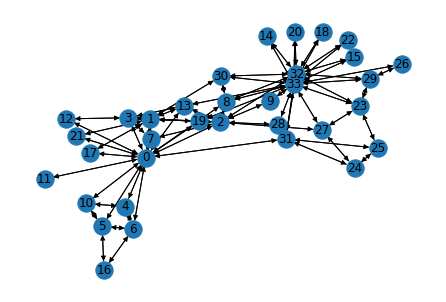

In [ ]:
# Create the DGL graph & draw it
dgl_karate_graph = KarateClubDataset()[0]
nx.draw(dgl_karate_graph.to_networkx(), with_labels=True)

name = "Karate"

# Delete the graph if it already exists
db.delete_graph(name, drop_collections=True, ignore_missing=True)

# Create the ArangoDB graph
adb_karate_graph = adbdgl_adapter.dgl_to_arangodb(name, dgl_karate_graph)

# You can also provide valid Python-Arango Import Bulk options to the command above, like such:
# adb_karate_graph = adbdgl_adapter.dgl_to_arangodb(name, dgl_karate_graph, batch_size=5, on_duplicate="replace")
# See the full parameter list at https://docs.python-arango.com/en/main/specs.html#arango.collection.Collection.import_bulk

print('\n--------------------')
print("URL: " + con["url"])
print("Username: " + con["username"])
print("Password: " + con["password"])
print("Database: " + con["dbName"])
print('--------------------\n')
print(f"View the created graph here: {con['url']}/_db/{con['dbName']}/_admin/aardvark/index.html#graph/{name}\n")
print(f"View the original graph below:\n")


#### FakeHeterogeneous Graph

Data
* A fake DGL Heterogeneous graph

API
*  `adbdgl_adapter.adapter.dgl_to_arangodb()`

Notes
* The `name` parameter is used to name your ArangoDB graph.

In [ ]:
# Create the PyG graph
hetero_graph = dgl.heterograph({
    ("user", "follows", "user"): (torch.tensor([0, 1]), torch.tensor([1, 2])),
    ("user", "follows", "topic"): (torch.tensor([1, 1]), torch.tensor([1, 2])),
    ("user", "plays", "game"): (torch.tensor([0, 3]), torch.tensor([3, 4])),
})
hetero_graph.nodes["user"].data["features"] = torch.tensor([21, 44, 16, 25])
hetero_graph.nodes["user"].data["label"] = torch.tensor([1, 2, 0, 1])
hetero_graph.nodes["game"].data["features"] = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1], [1, 1]])
hetero_graph.edges[("user", "plays", "game")].data["features"] = torch.tensor([[6, 1], [1000, 0]])

print(hetero_graph)

name = "FakeHetero"

# Delete the graph if it already exists
db.delete_graph(name, drop_collections=True, ignore_missing=True)

# Create the ArangoDB graphs
adb_hetero_graph = adbdgl_adapter.dgl_to_arangodb(name, hetero_graph)

print('\n--------------------')
print("URL: " + con["url"])
print("Username: " + con["username"])
print("Password: " + con["password"])
print("Database: " + con["dbName"])
print('--------------------\n')
print(f"View the created graph here: {con['url']}/_db/{con['dbName']}/_admin/aardvark/index.html#graph/{name}\n")
print(f"View the original graph below:\n")

Graph(num_nodes={'game': 5, 'topic': 3, 'user': 4},
      num_edges={('user', 'follows', 'topic'): 2, ('user', 'follows', 'user'): 2, ('user', 'plays', 'game'): 2},
      metagraph=[('user', 'topic', 'follows'), ('user', 'user', 'follows'), ('user', 'game', 'plays')])


Output()

Output()

Output()

Output()

Output()

Output()

[2022/08/05 20:35:24 +0000] [61] [INFO] - adbdgl_adapter: Created ArangoDB 'FakeHetero' Graph
INFO:adbdgl_adapter:Created ArangoDB 'FakeHetero' Graph



--------------------
URL: https://tutorials.arangodb.cloud:8529
Username: TUT6h05us6483maimfr7o28jq
Password: TUTis4noysrzjeig2bqpdccaa
Database: TUTk9nlikuz4zowwxfkusway
--------------------

View the created graph here: https://tutorials.arangodb.cloud:8529/_db/TUTk9nlikuz4zowwxfkusway/_admin/aardvark/index.html#graph/FakeHetero

View the original graph below:




#### FakeHeterogeneous Graph with a DGL-ArangoDB metagraph

Data
* A fake DGL Heterogeneous graph

API
*  `adbdgl_adapter.adapter.dgl_to_arangodb()`

Notes
* The `name` parameter is used to name your ArangoDB graph.
* The `metagraph` parameter is an optional object mapping the PyG keys of the node & edge data to  strings, list of strings, or user-defined functions.

In [ ]:
# Create the PyG graph
hetero_graph = dgl.heterograph({
    ("user", "follows", "user"): (torch.tensor([0, 1]), torch.tensor([1, 2])),
    ("user", "follows", "topic"): (torch.tensor([1, 1]), torch.tensor([1, 2])),
    ("user", "plays", "game"): (torch.tensor([0, 3]), torch.tensor([3, 4])),
})
hetero_graph.nodes["user"].data["features"] = torch.tensor([21, 44, 16, 25])
hetero_graph.nodes["user"].data["label"] = torch.tensor([1, 2, 0, 1])
hetero_graph.nodes["game"].data["features"] = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1], [1, 1]])
hetero_graph.edges[("user", "plays", "game")].data["features"] = torch.tensor([[6, 1], [1000, 0]])

print(hetero_graph)

name = "FakeHetero"

# Define the metagraph
def label_tensor_to_2_column_dataframe(dgl_tensor):
    """
    A user-defined function to create two
    ArangoDB attributes out of the 'user' label tensor

    NOTE: user-defined functions must return a Pandas Dataframe
    """
    label_map = {0: "Class A", 1: "Class B", 2: "Class C"}

    df = pandas.DataFrame(columns=["label_num", "label_str"])
    df["label_num"] = dgl_tensor.tolist()
    df["label_str"] = df["label_num"].map(label_map)

    return df


metagraph = {
    "nodeTypes": {
        "user": {
            "features": "user_age",  # 1) you can specify a string value for attribute renaming
            "label": label_tensor_to_2_column_dataframe,  # 2) you can specify a function for user-defined handling, as long as the function returns a Pandas DataFrame
        },
        # 3) You can specify set of strings if you want to preserve the same PyG attribute names for the node/edge type
        "game": {"features"} # this is equivalent to {"features": "features"}
    },
    "edgeTypes": {
        ("user", "plays", "game"): {
            # 4) you can specify a list of strings for tensor dissasembly (if you know the number of node/edge features in advance)
            "features": ["hours_played", "is_satisfied_with_game"]
        },
    },
}

# Delete the graph if it already exists
db.delete_graph(name, drop_collections=True, ignore_missing=True)

# Create the ArangoDB graphs
adb_hetero_graph = adbdgl_adapter.dgl_to_arangodb(name, hetero_graph, metagraph, explicit_metagraph=False)

# Create the ArangoDB graph with `explicit_metagraph=True`
# With `explicit_metagraph=True`, the node & edge types omitted from the metagraph will NOT be converted to ArangoDB.
# Only 'user', 'game', and ('user', 'plays', 'game') will be brought over (i.e 'topic', ('user', 'follows', 'user'), ... are ignored)
## adb_hetero_graph = adbdgl_adapter.dgl_to_arangodb(name, hetero_graph, metagraph, explicit_metagraph=True)

print('\n--------------------')
print("URL: " + con["url"])
print("Username: " + con["username"])
print("Password: " + con["password"])
print("Database: " + con["dbName"])
print('--------------------\n')
print(f"View the created graph here: {con['url']}/_db/{con['dbName']}/_admin/aardvark/index.html#graph/{name}\n")
print(f"View the original graph below:\n")

Graph(num_nodes={'game': 5, 'topic': 3, 'user': 4},
      num_edges={('user', 'follows', 'topic'): 2, ('user', 'follows', 'user'): 2, ('user', 'plays', 'game'): 2},
      metagraph=[('user', 'topic', 'follows'), ('user', 'user', 'follows'), ('user', 'game', 'plays')])


Output()

Output()

Output()

Output()

Output()

Output()

[2022/08/05 20:35:56 +0000] [61] [INFO] - adbdgl_adapter: Created ArangoDB 'FakeHetero' Graph
INFO:adbdgl_adapter:Created ArangoDB 'FakeHetero' Graph



--------------------
URL: https://tutorials.arangodb.cloud:8529
Username: TUT6h05us6483maimfr7o28jq
Password: TUTis4noysrzjeig2bqpdccaa
Database: TUTk9nlikuz4zowwxfkusway
--------------------

View the created graph here: https://tutorials.arangodb.cloud:8529/_db/TUTk9nlikuz4zowwxfkusway/_admin/aardvark/index.html#graph/FakeHetero

View the original graph below:




#### FakeHeterogeneous Graph with a user-defined ADBDGL Controller

Data
* A fake DGL Heterogeneous graph

API
*  `adbdgl_adapter.adapter.dgl_to_arangodb()`

Notes
* The `name` parameter is used to name your ArangoDB graph.
* The `ADBDGL_Controller` is an optional user-defined class for controlling how nodes & edges are handled when transitioning from PyG to ArangoDB. **It is interpreted as the alternative to the `metagraph` parameter.**

In [ ]:
# Create the PyG graph
hetero_graph = dgl.heterograph({
    ("user", "follows", "user"): (torch.tensor([0, 1]), torch.tensor([1, 2])),
    ("user", "follows", "topic"): (torch.tensor([1, 1]), torch.tensor([1, 2])),
    ("user", "plays", "game"): (torch.tensor([0, 3]), torch.tensor([3, 4])),
})
hetero_graph.nodes["user"].data["features"] = torch.tensor([21, 44, 16, 25])
hetero_graph.nodes["user"].data["label"] = torch.tensor([1, 2, 0, 1])
hetero_graph.nodes["game"].data["features"] = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1], [1, 1]])
hetero_graph.edges[("user", "plays", "game")].data["features"] = torch.tensor([[6, 1], [1000, 0]])

print(hetero_graph)

name = "FakeHetero"

# Create a custom ADBDGL_Controller
class Custom_ADBDGL_Controller(ADBDGL_Controller):
    def _prepare_dgl_node(self, dgl_node: dict, node_type: str) -> dict:
        """Optionally modify a DGL node object before it gets inserted into its designated ArangoDB collection.

        :param dgl_node: The DGL node object to (optionally) modify.
        :param node_type: The DGL Node Type of the node.
        :return: The DGL Node object
        """
        dgl_node["foo"] = "bar"
        return dgl_node

    def _prepare_dgl_edge(self, dgl_edge: dict, edge_type: tuple) -> dict:
        """Optionally modify a DGL edge object before it gets inserted into its designated ArangoDB collection.

        :param dgl_edge: The DGL edge object to (optionally) modify.
        :param edge_type: The Edge Type of the DGL edge. Formatted
            as (from_collection, edge_collection, to_collection)
        :return: The DGL Edge object
        """
        dgl_edge["bar"] = "foo"
        return dgl_edge

# Delete the graph if it already exists
db.delete_graph(name, drop_collections=True, ignore_missing=True)

# Create the ArangoDB graphs
adb_g = ADBDGL_Adapter(db, Custom_ADBDGL_Controller()).dgl_to_arangodb(name, hetero_graph)

print('\n--------------------')
print("URL: " + con["url"])
print("Username: " + con["username"])
print("Password: " + con["password"])
print("Database: " + con["dbName"])
print('--------------------\n')
print(f"View the created graph here: {con['url']}/_db/{con['dbName']}/_admin/aardvark/index.html#graph/{name}\n")
print(f"View the original graph below:\n")

Graph(num_nodes={'game': 5, 'topic': 3, 'user': 4},
      num_edges={('user', 'follows', 'topic'): 2, ('user', 'follows', 'user'): 2, ('user', 'plays', 'game'): 2},
      metagraph=[('user', 'topic', 'follows'), ('user', 'user', 'follows'), ('user', 'game', 'plays')])


[2022/08/05 20:36:18 +0000] [61] [INFO] - adbdgl_adapter: Instantiated ADBDGL_Adapter with database 'TUTk9nlikuz4zowwxfkusway'
INFO:adbdgl_adapter:Instantiated ADBDGL_Adapter with database 'TUTk9nlikuz4zowwxfkusway'


Output()

Output()

Output()

Output()

Output()

Output()

[2022/08/05 20:36:20 +0000] [61] [INFO] - adbdgl_adapter: Created ArangoDB 'FakeHetero' Graph
INFO:adbdgl_adapter:Created ArangoDB 'FakeHetero' Graph



--------------------
URL: https://tutorials.arangodb.cloud:8529
Username: TUT6h05us6483maimfr7o28jq
Password: TUTis4noysrzjeig2bqpdccaa
Database: TUTk9nlikuz4zowwxfkusway
--------------------

View the created graph here: https://tutorials.arangodb.cloud:8529/_db/TUTk9nlikuz4zowwxfkusway/_admin/aardvark/index.html#graph/FakeHetero

View the original graph below:



# <u>ArangoDB to DGL</u>



In [ ]:
# Start from scratch! (with the same DGL graph)
hetero_graph = dgl.heterograph({
    ("user", "follows", "user"): (torch.tensor([0, 1]), torch.tensor([1, 2])),
    ("user", "follows", "topic"): (torch.tensor([1, 1]), torch.tensor([1, 2])),
    ("user", "plays", "game"): (torch.tensor([0, 3]), torch.tensor([3, 4])),
})
hetero_graph.nodes["user"].data["features"] = torch.tensor([21, 44, 16, 25])
hetero_graph.nodes["user"].data["label"] = torch.tensor([1, 2, 0, 1])
hetero_graph.nodes["game"].data["features"] = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1], [1, 1]])
hetero_graph.edges[("user", "plays", "game")].data["features"] = torch.tensor([[6, 1], [1000, 0]])

db.delete_graph("FakeHetero", drop_collections=True, ignore_missing=True)
adbdgl_adapter.dgl_to_arangodb("FakeHetero", hetero_graph)

Output()

Output()

Output()

Output()

Output()

Output()

[2022/08/05 20:36:46 +0000] [61] [INFO] - adbdgl_adapter: Created ArangoDB 'FakeHetero' Graph
INFO:adbdgl_adapter:Created ArangoDB 'FakeHetero' Graph


<Graph FakeHetero>

#### Via ArangoDB Graph

Data
* A fake DGL Heterogeneous graph

API
* `adbdgl_adapter.adapter.arangodb_graph_to_dgl()`

Notes
* The `name` parameter in this case must point to an existing ArangoDB graph in your ArangoDB instance.
* Due to risk of ambiguity, this method does **not** carry over ArangoDB attributes to DGL.

In [ ]:
# Define graph name
name = "FakeHetero"

# Create DGL graph from the ArangoDB graph
dgl_g = adbdgl_adapter.arangodb_graph_to_dgl(name)

# You can also provide valid Python-Arango AQL query options to the command above, like such:
# dgl_g = adbdgl_adapter.arangodb_graph_to_dgl(graph_name, ttl=1000, stream=True)
# See the full parameter list at https://docs.python-arango.com/en/main/specs.html#arango.aql.AQL.execute

# Show graph data
print('\n--------------------')
print(dgl_g)
print(dgl_g.ndata) # note how this is empty
print(dgl_g.edata) # note how this is empty

Output()

Output()

Output()

Output()

Output()

[2022/08/05 20:37:12 +0000] [61] [INFO] - adbdgl_adapter: Created DGL 'FakeHetero' Graph
INFO:adbdgl_adapter:Created DGL 'FakeHetero' Graph



--------------------
defaultdict(<class 'dict'>, {})


#### Via ArangoDB Collections

Data
* A fake DGL Heterogeneous graph

API
* `adbdgl_adapter.adapter.arangodb_collections_to_dgl()`

Notes
* The `name` parameter is purely for documentation purposes in this case.
* The `vertex_collections` & `edge_collections` parameters must point to existing ArangoDB collections within your ArangoDB instance.
* Due to risk of ambiguity, this method does **not** carry over ArangoDB attributes to DGL.

In [ ]:
name = "FakeHetero"

dgl_g = adbdgl_adapter.arangodb_collections_to_dgl(
    name,
    v_cols={"user", "game"},
    e_cols={"plays", "follows"}
)

# Show graph data (notice that the "topic" data is skipped)
print('\n--------------------')
print(dgl_g)
print(dgl_g.ndata) # note how this is empty
print(dgl_g.edata) # note how this is empty

Output()

Output()

Output()

Output()

Output()

[2022/08/05 20:37:50 +0000] [61] [INFO] - adbdgl_adapter: Created DGL 'FakeHetero' Graph
INFO:adbdgl_adapter:Created DGL 'FakeHetero' Graph



--------------------
Graph(num_nodes={'game': 5, 'topic': 3, 'user': 4},
      num_edges={('user', 'follows', 'topic'): 2, ('user', 'follows', 'user'): 2, ('user', 'plays', 'game'): 2},
      metagraph=[('user', 'topic', 'follows'), ('user', 'user', 'follows'), ('user', 'game', 'plays')])
defaultdict(<class 'dict'>, {})
defaultdict(<class 'dict'>, {})


#### Via ArangoDB-DGL metagraph 1

Data
* A fake DGL Heterogeneous graph

API
* `adbdgl_adapter.adapter.arangodb_to_dgl()`

Notes
* The `name` parameter is purely for documentation purposes in this case.
* The `metagraph` parameter is an object defining vertex & edge collections to import to DGL, along with collection-level specifications to indicate which ArangoDB attributes will become DGL features/labels. It should contain collections & associated document attributes names that exist within your ArangoDB instance.

In [ ]:
# Define the Metagraph that transfers ArangoDB attributes "as is",
# meaning the data is already formatted to DGL data standards
metagraph_v1 = {
    "vertexCollections": {
        # Move the "features" & "label" ArangoDB attributes to DGL as "features" & "label" Tensors
        "user": {"features", "label"}, # equivalent to {"features": "features", "label": "label"}
        "game": {"dgl_game_features": "features"},
        "topic": {},
    },
    "edgeCollections": {
        "plays": {"dgl_plays_features": "features"},
        "follows": {}
    },
}

# Create the DGL graph
dgl_g = adbdgl_adapter.arangodb_to_dgl("FakeHetero", metagraph_v1)

# Show graph data
print('\n--------------')
print(dgl_g)
print('\n--------------')
print(dgl_g.ndata)
print('--------------\n')
print(dgl_g.edata)

Output()

Output()

Output()

Output()

Output()

[2022/08/05 20:38:02 +0000] [61] [INFO] - adbdgl_adapter: Created DGL 'FakeHetero' Graph
INFO:adbdgl_adapter:Created DGL 'FakeHetero' Graph



--------------
Graph(num_nodes={'game': 5, 'topic': 3, 'user': 4},
      num_edges={('user', 'follows', 'topic'): 2, ('user', 'follows', 'user'): 2, ('user', 'plays', 'game'): 2},
      metagraph=[('user', 'topic', 'follows'), ('user', 'user', 'follows'), ('user', 'game', 'plays')])

--------------
defaultdict(<class 'dict'>, {'dgl_game_features': {'game': tensor([[0, 0],
        [0, 1],
        [1, 0],
        [1, 1],
        [1, 1]])}, 'label': {'user': tensor([1, 2, 0, 1])}, 'features': {'user': tensor([21, 44, 16, 25])}})
--------------

defaultdict(<class 'dict'>, {'dgl_plays_features': {('user', 'plays', 'game'): tensor([[   6,    1],
        [1000,    0]])}})


#### Via ArangoDB-DGL metagraph 2

Data
* [ArangoDB IMDB Movie Dataset](https://www.arangodb.com/docs/stable/arangosearch-example-datasets.html#imdb-movie-dataset)

API
* `adbddgl_adapter.adapter.arangodb_to_dgl()`

Notes
* The `name` parameter is purely for documentation purposes in this case.
* The `metagraph` parameter is an object defining vertex & edge collections to import to DGL, along with collection-level specifications to indicate which ArangoDB attributes will become PyG features/labels. In this example, we rely on user-defined encoders to build PyG-ready tensors (i.e feature matrices) from ArangoDB attributes. See https://pytorch-geometric.readthedocs.io/en/latest/notes/load_csv.html for an example on using encoders.

In [ ]:
# Define the Metagraph that transfers attributes via user-defined encoders
metagraph_v2 = {
    "vertexCollections": {
        "Movies": {
            "features": {  # Build a feature matrix from the "Action" & "Drama" document attributes
                "Action": IdentityEncoder(dtype=torch.long),
                "Drama": IdentityEncoder(dtype=torch.long),
            },
            "label": "Comedy",
        },
        "Users": {
            "features": {
                "Gender": CategoricalEncoder(), # CategoricalEncoder(mapping={"M": 0, "F": 1}),
                "Age": IdentityEncoder(dtype=torch.long),
            }
        },
    },
    "edgeCollections": {"Ratings": {"weight": "Rating"}},
}

# Create the DGL Graph
dgl_g = adbdgl_adapter.arangodb_to_dgl("IMDB", metagraph_v2)

# Show graph data
print('\n--------------')
print(dgl_g)
print('\n--------------')
print(dgl_g.ndata)
print('--------------\n')
print(dgl_g.edata)

Output()

Output()

Output()

[2022/08/05 20:38:44 +0000] [61] [INFO] - adbdgl_adapter: Created DGL 'IMDB' Graph
INFO:adbdgl_adapter:Created DGL 'IMDB' Graph



--------------
Graph(num_nodes={'Movies': 1682, 'Users': 943},
      num_edges={('Users', 'Ratings', 'Movies'): 65499},
      metagraph=[('Users', 'Movies', 'Ratings')])

--------------
defaultdict(<class 'dict'>, {'features': {'Movies': tensor([[0, 0],
        [1, 0],
        [0, 0],
        ...,
        [0, 1],
        [0, 0],
        [0, 1]]), 'Users': tensor([[ 0., 35.],
        [ 1., 53.],
        [ 0., 23.],
        ...,
        [ 0., 20.],
        [ 1., 48.],
        [ 0., 22.]])}, 'label': {'Movies': tensor([1, 0, 0,  ..., 0, 1, 0])}})
--------------

{'weight': tensor([4, 4, 3,  ..., 4, 4, 4])}


#### Via ArangoDB-DGL metagraph 3

Data
* A fake DGL Heterogeneous graph

API
* `adbdgl_adapter.adapter.arangodb_to_dgl()`

Notes
* The `name` parameter is purely for documentation purposes in this case.
* The `metagraph` parameter is an object defining vertex & edge collections to import to DGL, along with collection-level specifications to indicate which ArangoDB attributes will become DGL features/labels. In this example, we rely on user-defined functions to handle ArangoDB attribute to DGL feature conversion.

In [ ]:
# Define the metagraph that transfers attributes via user-defined functions
def udf_user_features(user_df):
    # process the user_df Pandas DataFrame to return a feature matrix in a tensor
    # user_df["features"] = ...
    return torch.tensor(user_df["features"].to_list())


def udf_game_features(game_df):
    # process the game_df Pandas DataFrame to return a feature matrix in a tensor
    # game_df["features"] = ...
    return torch.tensor(game_df["features"].to_list())


metagraph_v3 = {
    "vertexCollections": {
        "user": {
            "features": udf_user_features,  # supports named functions
            "label": lambda df: torch.tensor(df["label"].to_list()),  # also supports lambda functions
        },
        "game": {"features": udf_game_features},
    },
    "edgeCollections": {
        "plays": {"features": (lambda df: torch.tensor(df["features"].to_list()))},
    },
}

# Create PyG Graph
dgl_g = adbdgl_adapter.arangodb_to_dgl("FakeHetero", metagraph_v3)

# Show graph data
print('\n--------------')
print(dgl_g)
print('\n--------------')
print(dgl_g.ndata)
print('--------------\n')
print(dgl_g.edata)

Output()

Output()

Output()

[2022/08/05 20:39:00 +0000] [61] [INFO] - adbdgl_adapter: Created DGL 'FakeHetero' Graph
INFO:adbdgl_adapter:Created DGL 'FakeHetero' Graph



--------------
Graph(num_nodes={'game': 5, 'user': 4},
      num_edges={('user', 'plays', 'game'): 2},
      metagraph=[('user', 'game', 'plays')])

--------------
defaultdict(<class 'dict'>, {'features': {'game': tensor([[0, 0],
        [0, 1],
        [1, 0],
        [1, 1],
        [1, 1]]), 'user': tensor([21, 44, 16, 25])}, 'label': {'user': tensor([1, 2, 0, 1])}})
--------------

{'features': tensor([[   6,    1],
        [1000,    0]])}
